# Detector dead time peak shift test

The type of detectors we are using at P61A is known to produce erroneous energy histograms when saturated. 
Dead time is a measure of detector saturation (amount of accepted events divided by all events during acquisition time). 

This is the analysis of data acquired on 04.09.2021 using NIST 640f reference powder as sample and graphite plates in the experimental hutch as beam intensity control. In a perfect measurement peak position for both diffraction and fluorescence would stay constant regardless of the number of graphite plates.

XSpress dead time data was only collected for detector (channel) 1.

Project file: `Z:\p61\2021\data\11012376\processed\si_dt.pickle`

Dataset: `data\peaks\si_dt.csv`

In [59]:
import sys
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from uncertainties import unumpy, ufloat

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# This has to be the path to P61AToolkit/src/py61a.
# If you are launching the notebook from P61AToolkit/src/notebooks it is correct,
# otherwise change it accordingly.
sys.path.append('../py61a')
from py61a.viewer_utils import read_peaks, valid_peaks, peak_id_str, group_by_motors
from py61a.cryst_utils import bragg, tau, mu
from py61a.stress import sin2psi, deviatoric_stresses, all_stresses

%matplotlib inline

In [60]:
dt_re = re.compile(r'si_(?P<GP>[\d]+)gp_(?P<DT1>[\d]+)p(?P<DT2>[\d]+)dt_')

def dt_from_filename(row):
    match_groups = dt_re.match(row['md']['ScreenName']).groups()
    row.loc[('md', 'GraphiteAbs')] = int(match_groups[0])
    row.loc[('md', 'XspressDT')] = float(match_groups[1]) + float(match_groups[2]) / 10**len(match_groups[2])
    return row

data = read_peaks(r'../../data/peaks/si_dt.csv')
data = data.apply(dt_from_filename, axis=1)
data

prefix                               md                                      \
parameter                    ScreenName Channel       Chi2  DeadTime eu.alp   
0          si_10gp_14p23dt_00255.nxs:01       1   2.354735  0.000028    NaN   
1          si_11gp_12p69dt_00256.nxs:01       1   2.185133  0.000030    NaN   
2          si_12gp_11p38dt_00257.nxs:01       1   1.862754  0.000031    NaN   
3          si_13gp_10p13dt_00258.nxs:01       1   1.750022  0.000035    NaN   
4           si_14gp_9p14dt_00259.nxs:01       1   1.659994  0.000036    NaN   
5           si_15gp_8p12dt_00260.nxs:01       1   1.741803  0.000042    NaN   
6           si_16gp_7p21dt_00261.nxs:01       1   1.358279  0.000045    NaN   
7           si_17gp_6p48dt_00262.nxs:01       1   1.292544  0.000050    NaN   
8           si_18gp_5p78dt_00263.nxs:01       1   1.621286  0.000057    NaN   
9           si_19gp_5p29dt_00264.nxs:01       1   1.384693  0.000074    NaN   
10          si_1gp_35p35dt_00246.nxs:01       1  12.646615  0.000041    NaN   
11          si_20gp_4p76dt_00265.nxs:01       1   1.313248  0.000111    NaN   
12          si_21gp_4p32dt_00266.nxs:01       1   1.206702  0.000180    NaN   
13           si_22gp_3p9dt_00267.nxs:01       1   1.217678  0.000264    NaN   
14          si_23gp_3p57dt_00268.nxs:01       1   1.150408  0.000376    NaN   
15          si_24gp_3p28dt_00269.nxs:01       1   1.270597  0.000530    NaN   
16           si_25gp_3p0dt_00270.nxs:01       1   1.191448  0.000678    NaN   
17          si_2gp_32p20dt_00247.nxs:01       1  10.799205  0.000037    NaN   
18          si_3gp_29p78dt_00248.nxs:01       1   8.346187  0.000032    NaN   
19          si_4gp_26p78dt_00249.nxs:01       1   6.890891  0.000031    NaN   
20          si_5gp_24p34dt_00250.nxs:01       1   6.363210  0.000028    NaN   
21          si_6gp_21p93dt_00251.nxs:01       1   4.367595  0.000028    NaN   
22          si_7gp_19p75dt_00252.nxs:01       1   3.748996  0.000027    NaN   
23          si_8gp_17p70dt_00253.nxs:01       1   4.240334  0.000027    NaN   
24          si_9gp_15p94dt_00254.nxs:01       1   2.721162  0.000026    NaN   

prefix                                    ...           pv9               \
parameter eu.bet eu.chi eu.phi eu.x eu.y  ...  fraction_std       height   
0            NaN    NaN    NaN  NaN  NaN  ...  6.416070e-06  1758.718178   
1            NaN    NaN    NaN  NaN  NaN  ...  4.343667e-06  1670.072101   
2            NaN    NaN    NaN  NaN  NaN  ...  5.234222e-06  1750.990470   
3            NaN    NaN    NaN  NaN  NaN  ...  5.385769e-06  1774.721906   
4            NaN    NaN    NaN  NaN  NaN  ...  6.202140e-06  1703.630844   
5            NaN    NaN    NaN  NaN  NaN  ...  7.132819e-06  1726.457759   
6            NaN    NaN    NaN  NaN  NaN  ...  6.683867e-06  1755.717745   
7            NaN    NaN    NaN  NaN  NaN  ...  6.043140e-06  1719.286707   
8            NaN    NaN    NaN  NaN  NaN  ...  6.314192e-06  1816.204089   
9            NaN    NaN    NaN  NaN  NaN  ...  1.015158e-05  1592.064567   
10           NaN    NaN    NaN  NaN  NaN  ...  4.006981e+05     4.852259   
11           NaN    NaN    NaN  NaN  NaN  ...  7.245002e-06  1763.230310   
12           NaN    NaN    NaN  NaN  NaN  ...  6.548265e-06  1764.002660   
13           NaN    NaN    NaN  NaN  NaN  ...  1.018121e-05  1523.347457   
14           NaN    NaN    NaN  NaN  NaN  ...  8.883203e-06  1650.860538   
15           NaN    NaN    NaN  NaN  NaN  ...  9.728228e-06  1564.336817   
16           NaN    NaN    NaN  NaN  NaN  ...  1.174364e-05  1558.105423   
17           NaN    NaN    NaN  NaN  NaN  ...  1.867913e-05   447.491302   
18           NaN    NaN    NaN  NaN  NaN  ...  7.484487e-06   970.109181   
19           NaN    NaN    NaN  NaN  NaN  ...  4.583881e-06  1195.036612   
20           NaN    NaN    NaN  NaN  NaN  ...  5.301091e-06  1183.652893   
21           NaN    NaN    NaN  NaN  NaN  ...  4.468190e-06  1538.924279   
22           NaN    NaN    NaN  NaN  NaN  

## Tango DT vs XSpress DT

First let us see the relationship between the dead time given by Xspress controls and the one we calculate using Tango output of `allgood` / `allevent`.

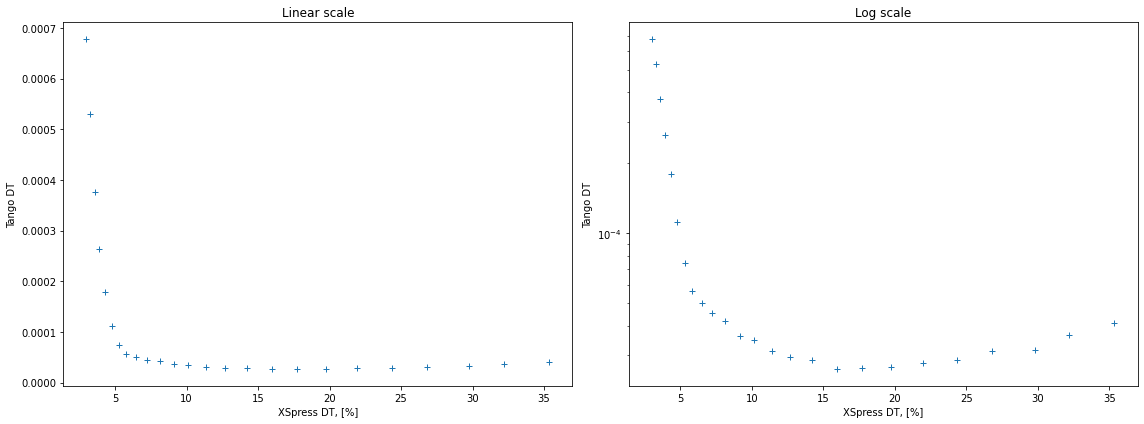

In [61]:
plt.figure(figsize=(16, 6))
plt.subplot(121).set_title('Linear scale')
plt.plot(data[('md', 'XspressDT')], data[('md', 'DeadTime')], '+')
plt.xlabel('XSpress DT, [%]')
plt.ylabel('Tango DT')
plt.subplot(122).set_title('Log scale')
plt.semilogy(data[('md', 'XspressDT')], data[('md', 'DeadTime')], '+')
plt.xlabel('XSpress DT, [%]')
plt.ylabel('Tango DT')
plt.tight_layout()
plt.show()

## Diffraction peak positions vs dead time

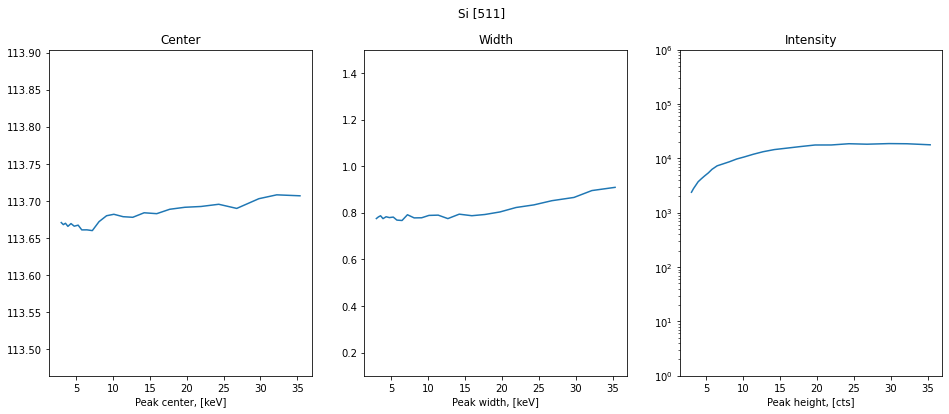

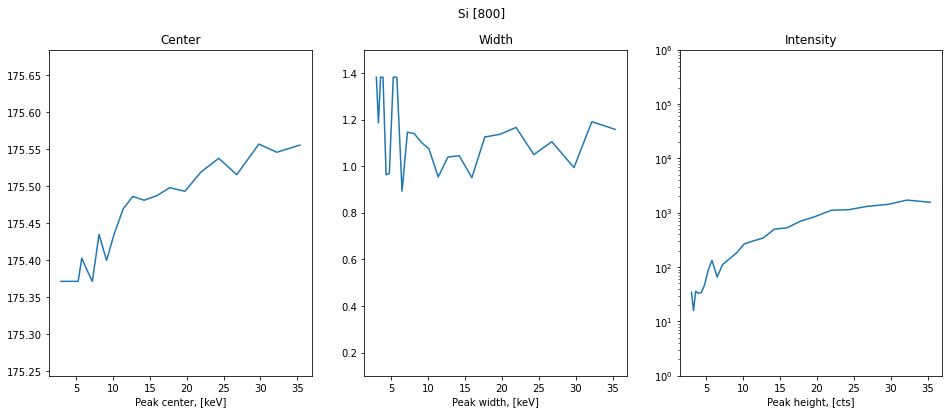

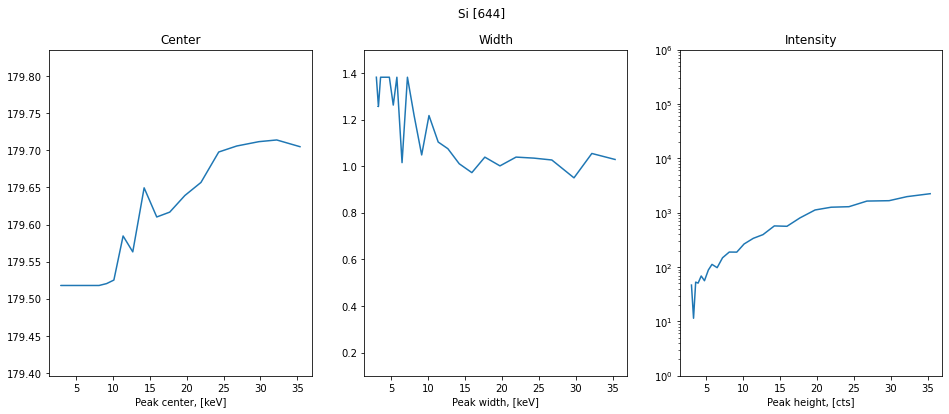

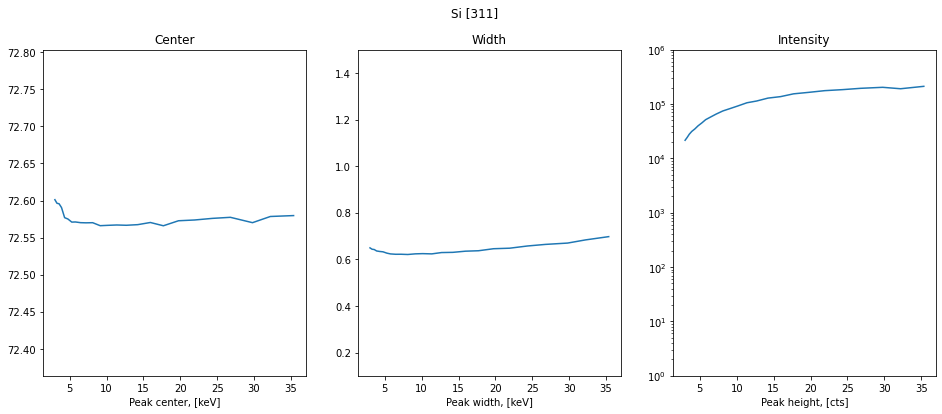

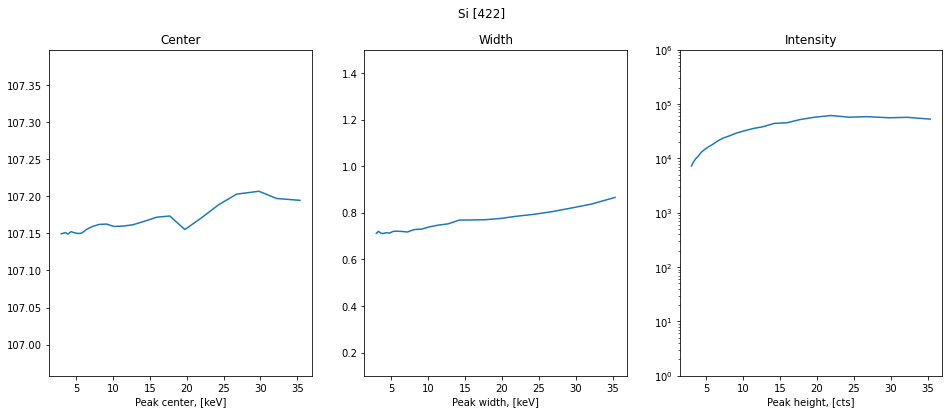

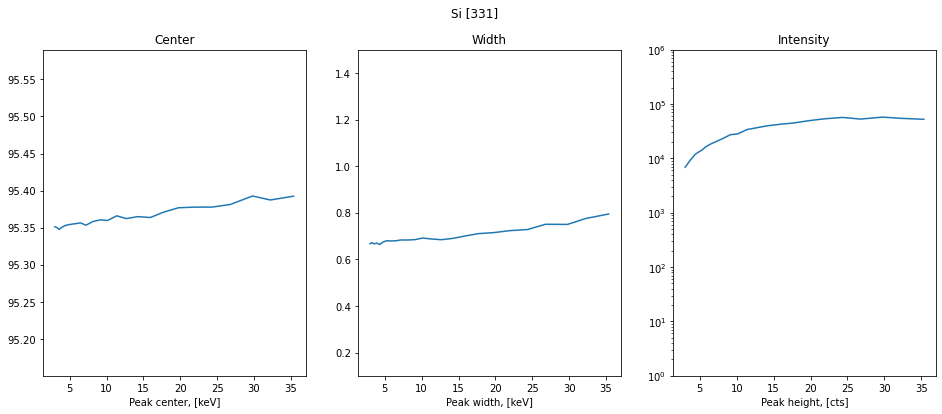

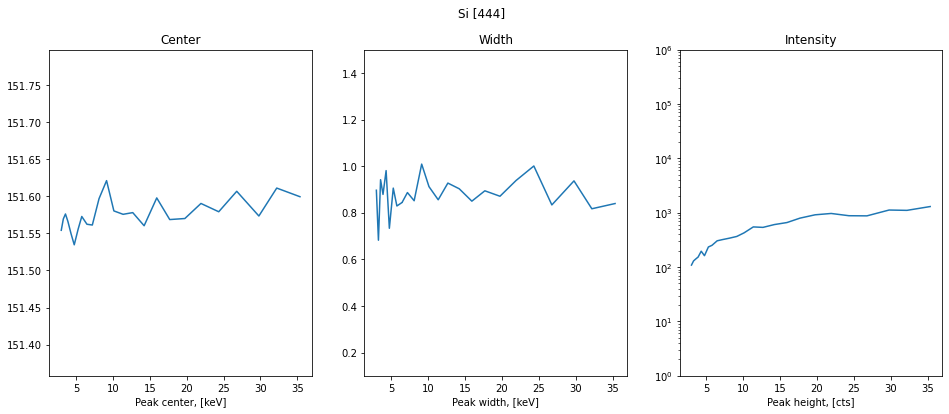

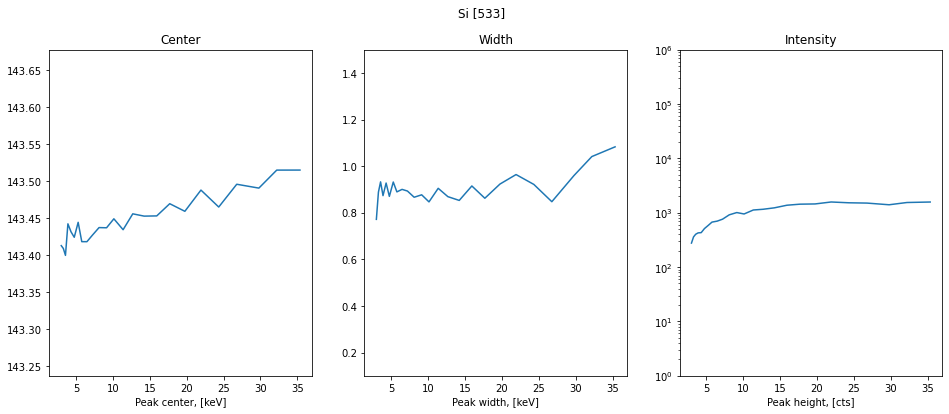

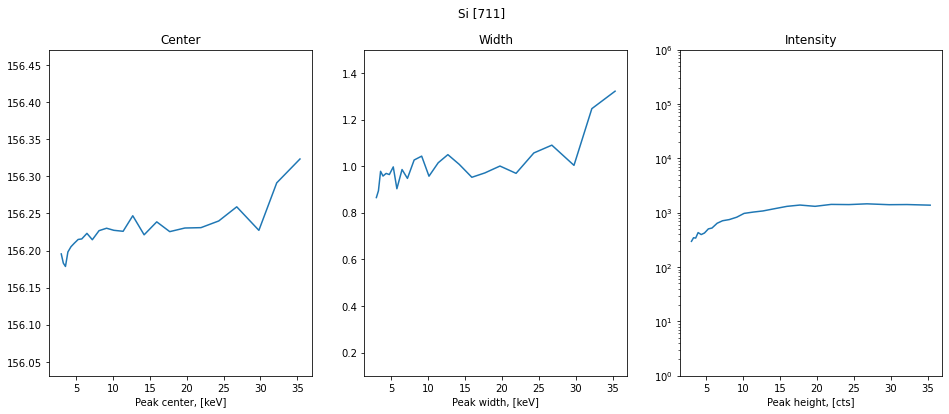

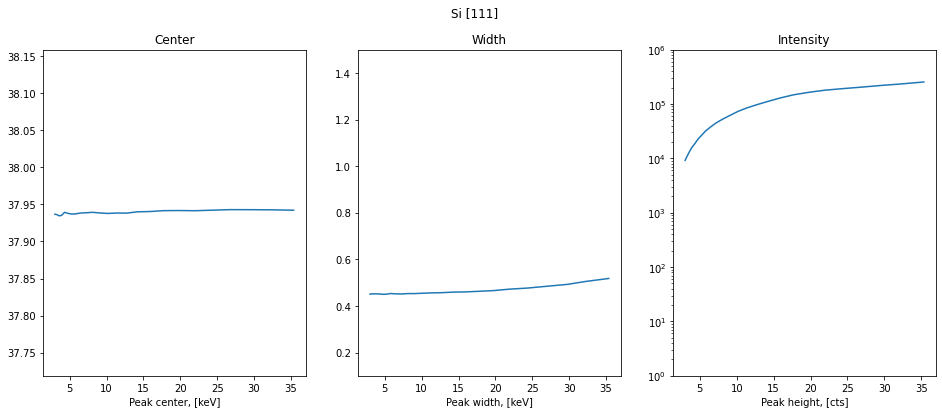

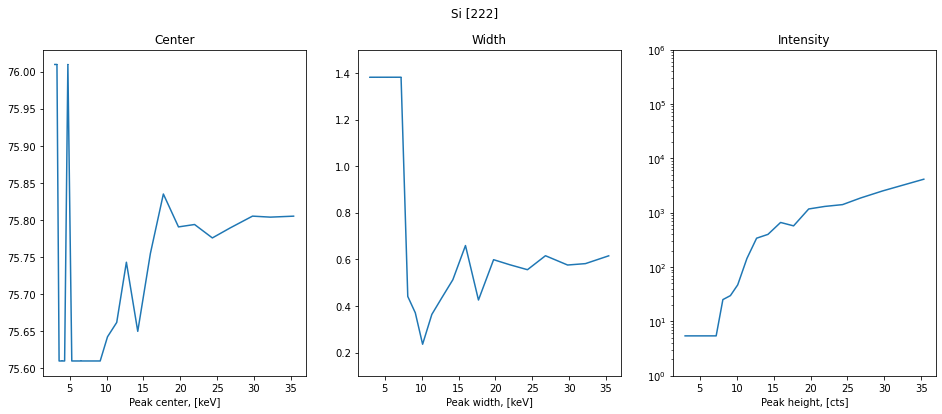

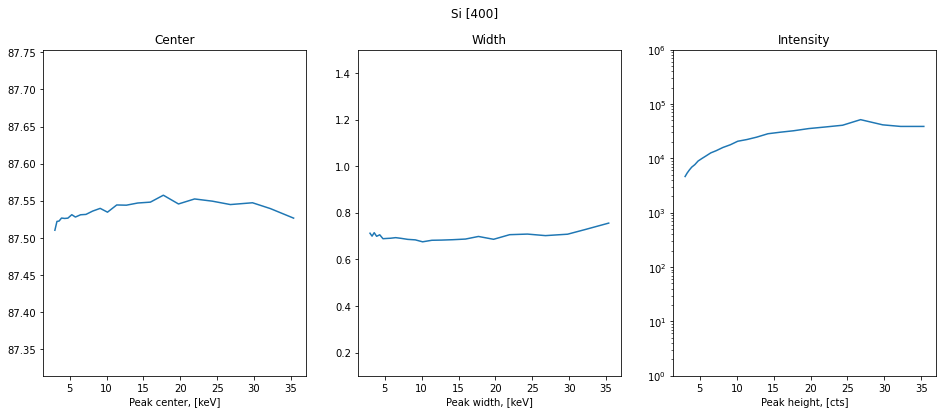

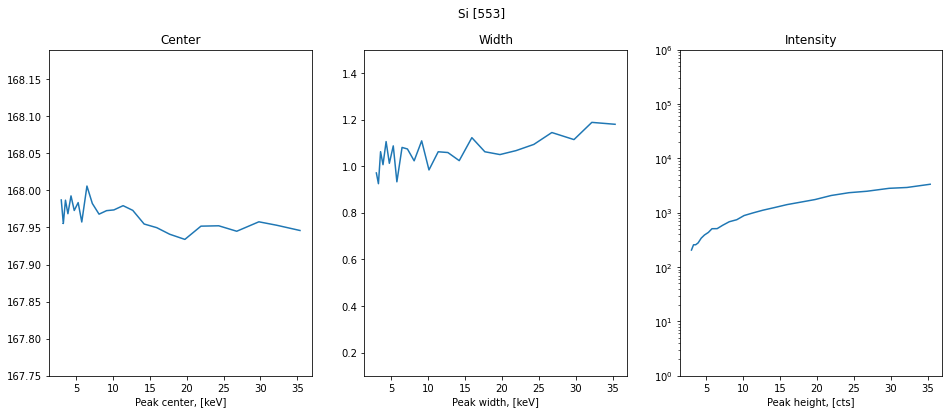

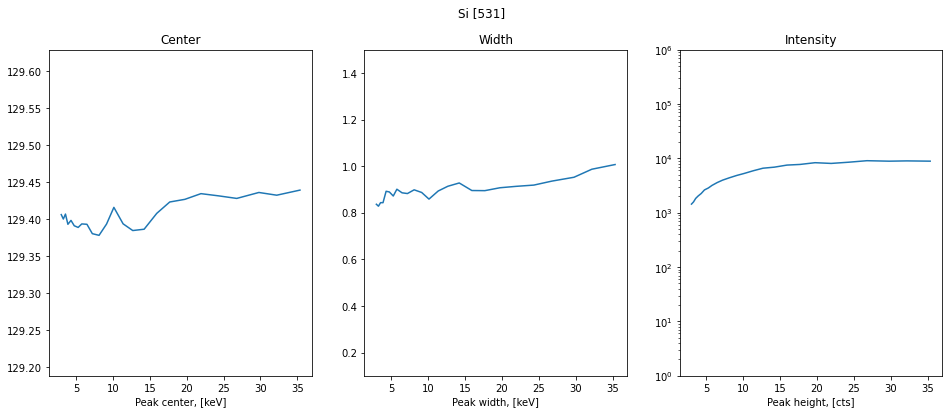

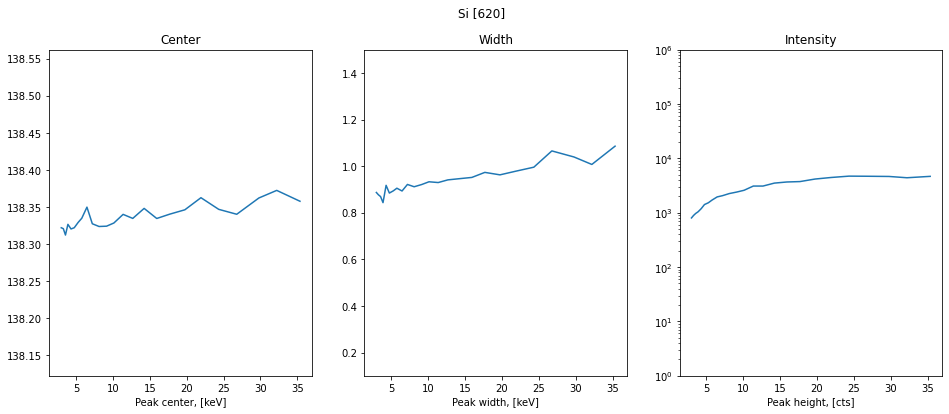

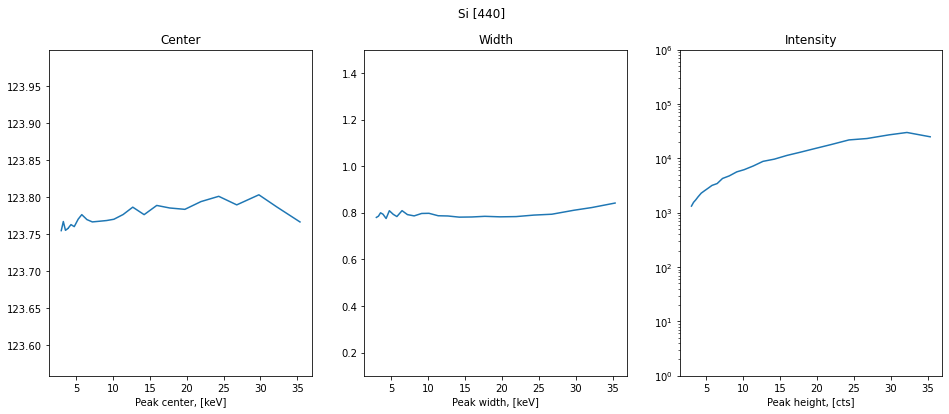

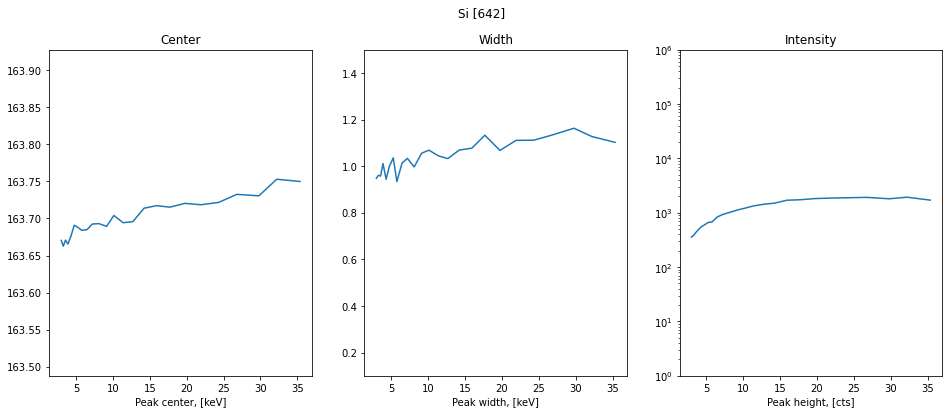

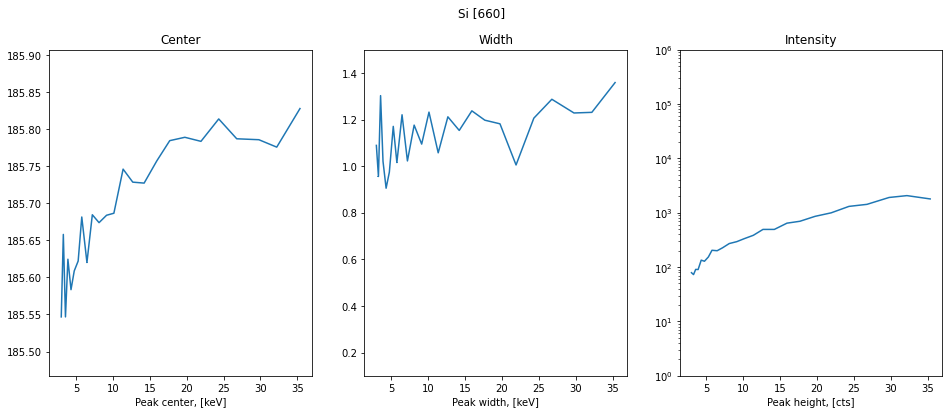

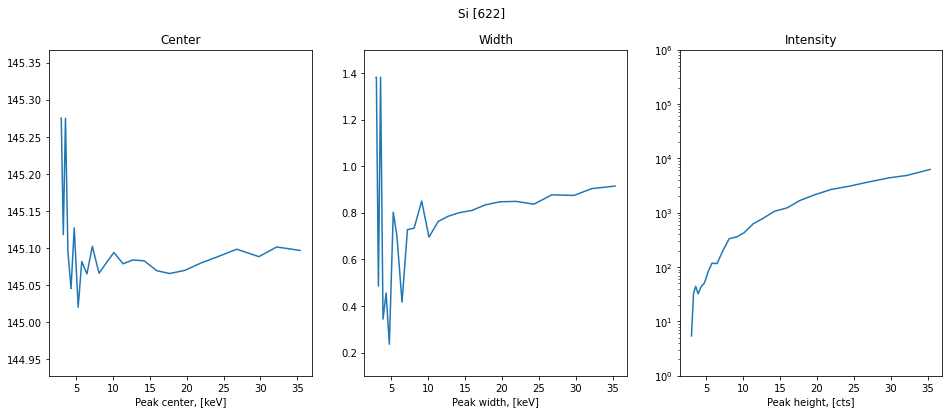

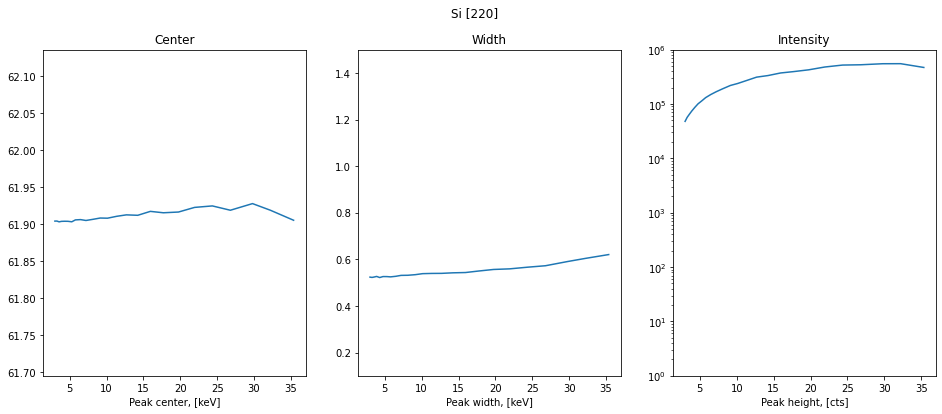

In [62]:
data.sort_values(by=('md', 'XspressDT'), inplace=True)

cdiff = 0.
for peak_id in valid_peaks(data, valid_for='phase'):
    if (data[peak_id]['center'].max() - data[peak_id]['center'].min()) > cdiff:
        cdiff = data[peak_id]['center'].max() - data[peak_id]['center'].min()

for peak_id in valid_peaks(data, valid_for='phase'):
    plt.figure(peak_id_str(data, peak_id), figsize=(16, 6)).suptitle(peak_id_str(data, peak_id))
    plt.subplot(131).set_title('Center')
    plt.errorbar(data['md']['XspressDT'], data[peak_id]['center'], yerr=data[peak_id]['center_std'])
    plt.ylim(
        0.5 * (data[peak_id]['center'].min() + data[peak_id]['center'].max()) - 0.55 * cdiff, 
        0.5 * (data[peak_id]['center'].min() + data[peak_id]['center'].max()) + 0.55 * cdiff
    )
    plt.xlabel('XSpress dead time, [%]')
    plt.xlabel('Peak center, [keV]')
    plt.subplot(132).set_title('Width')
    plt.errorbar(data['md']['XspressDT'], data[peak_id]['width'], yerr=data[peak_id]['width_std'])
    plt.xlabel('XSpress dead time, [%]')
    plt.xlabel('Peak width, [keV]')
    plt.ylim(0.1, 1.5)
    ax = plt.subplot(133)
    ax.set_title('Intensity')
    ax.set_yscale('log')
    plt.errorbar(data['md']['XspressDT'], data[peak_id]['height'], yerr=data[peak_id]['height_std'])
    plt.xlabel('XSpress dead time, [%]')
    plt.xlabel('Peak height, [cts]')
    plt.ylim(1., 1E6)